<a href="https://colab.research.google.com/github/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/VGG19_Diagnosis_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG19 Model Application

This notebook applied a pre-trained model to a dataset specified in the configuration file and uploads the labels to the catalog.  The ROC curve is also calculated and uploaded.


In [1]:
# Prerequisites to configure colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install deriva
    !pip install bdbag
    !pip install --upgrade --force pydantic
    !pip install git+https://github.com/informatics-isi-edu/deriva-ml git+https://github.com/informatics-isi-edu/eye-ai-ml
    !pip install setuptools_git_versioning


In [2]:
repo_dir = "Repos"   # Set this to be where your github repos are located.
%load_ext autoreload
%autoreload 2

# Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-ml"))

In [3]:
# Prerequisites

import json
import os
from eye_ai.eye_ai import EyeAI
import pandas as pd
from pathlib import Path, PurePath
import logging
# import torch

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

In [4]:

from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
catalog_id = "eye-ai" #@param
host = 'www.eye-ai.org'


gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2024-06-26 07:51:20,844 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-06-26 07:51:20,845 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


Connect to Eye-AI catalog.  Configure to store data local cache and working directories.  Initialize Eye-AI for pending execution based on the provided configuration file.

In [5]:
# Variables to configure the rest of the notebook.

cache_dir = '/data'        # Directory in which to cache materialized BDBags for datasets
working_dir = '/data'    # Directory in which to place output files for later upload.

configuration_rid="2-C6DP"      # Configuration file for this run.  Needs to be changed for each execution.

In [6]:
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2024-06-26 07:51:20,882 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-06-26 07:51:20,882 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [7]:
# @title Initiate an Execution
configuration_records = EA.execution_init(configuration_rid=configuration_rid)
input_dataset = configuration_records.bag_paths[0] # Assumes that the configuration file only specifies one dataset.
configuration_records.model_dump()



2024-06-26 07:51:21,239 - INFO - File [/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_diagnosis_insert_june_26_best_params.json] transfer successful. 0.81 KB transferred. Elapsed time: 0:00:00.000094.
2024-06-26 07:51:21,240 - INFO - Verifying MD5 checksum for downloaded file [/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_diagnosis_insert_june_26_best_params.json]
2024-06-26 07:51:21,258 - INFO - Configuration validation successful!
2024-06-26 07:51:28,133 - INFO - File [/data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Catalog_LAC_DHS_Cropped_Data_exlcuding_no_Optic_disc_fundus_Trained_model_June_24_2024.h5] transfer successful. 232.71 MB transferred at 54.09 MB/second. Elapsed time: 0:00:04.302132.
2024-06-26 07:51:29,224 - INFO - File [/data/sreenidhi/EyeAI_working/Execution_Assets/best_hyperparameters_exluding_no_optic_disc_images_june_24_2024.json] transfer successful. 0.69 KB transferred

{'caching_dir': PosixPath('/data'),
 'working_dir': PosixPath('/data/sreenidhi/EyeAI_working'),
 'vocabs': {'Workflow_Type': [{'name': 'Diagnosis', 'rid': '2-7J8T'}],
  'Diagnosis_Tag': [{'name': 'CNN_Prediction', 'rid': '2-7KBR'}]},
 'execution_rid': '2-C6E0',
 'workflow_rid': '2-A5QA',
 'bag_paths': [PosixPath('/data/2-277M_6b713c2652c2d45c4bc0e0633e9a739569e98dcf0f10d3cfd403e29468d9d5d0/Dataset_2-277M')],
 'assets_paths': [PosixPath('/data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Catalog_LAC_DHS_Cropped_Data_exlcuding_no_Optic_disc_fundus_Trained_model_June_24_2024.h5'),
  PosixPath('/data/sreenidhi/EyeAI_working/Execution_Assets/best_hyperparameters_exluding_no_optic_disc_images_june_24_2024.json')],
 'configuration_path': PosixPath('/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_diagnosis_insert_june_26_best_params.json')}

Algorithm was trained on cropped images, so take the raw images and bounding boxes and apply, storing the results in the working directory.

In [8]:
configuration_records

ConfigurationRecord(caching_dir=PosixPath('/data'), working_dir=PosixPath('/data/sreenidhi/EyeAI_working'), vocabs={'Workflow_Type': [Term(name='Diagnosis', rid='2-7J8T')], 'Diagnosis_Tag': [Term(name='CNN_Prediction', rid='2-7KBR')]}, execution_rid='2-C6E0', workflow_rid='2-A5QA', bag_paths=[PosixPath('/data/2-277M_6b713c2652c2d45c4bc0e0633e9a739569e98dcf0f10d3cfd403e29468d9d5d0/Dataset_2-277M')], assets_paths=[PosixPath('/data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Catalog_LAC_DHS_Cropped_Data_exlcuding_no_Optic_disc_fundus_Trained_model_June_24_2024.h5'), PosixPath('/data/sreenidhi/EyeAI_working/Execution_Assets/best_hyperparameters_exluding_no_optic_disc_images_june_24_2024.json')], configuration_path=PosixPath('/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_diagnosis_insert_june_26_best_params.json'))

In [9]:
str(EA.working_dir)

'/data/sreenidhi/EyeAI_working'

In [10]:
# @title Get Cropped Images
cropped_image_path, cropped_csv = EA.create_cropped_images(str(configuration_records.bag_paths[0]),
                                                           output_dir = str(EA.working_dir),
                                                           crop_to_eye=True)

In [11]:
best_hyper_parameters_json_path = str(configuration_records.assets_paths[1])
best_hyper_parameters_json_path

'/data/sreenidhi/EyeAI_working/Execution_Assets/best_hyperparameters_exluding_no_optic_disc_images_june_24_2024.json'

Import the actual model code and then run against the input dataset specified in the configuration file.  

In [12]:
# @title Execute Proecss algorithm (Test model)
from eye_ai.models.vgg19_diagnosis_predict import prediction

with EA.execution(execution_rid=configuration_records.execution_rid) as exec:
  output_path = EA.execution_assets_path/Path("Model_Prediction")
  pred_csv_path = prediction(configuration_records.assets_paths[0], cropped_image_path, output_path, best_hyper_parameters_json_path)

2024-06-26 07:52:27.133641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 07:52:27.133687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 07:52:27.134538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 07:52:27.140888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 07:52:27.917907: W tensorflow/compiler/tf2

Found 1094 images belonging to 2 classes.


2024-06-26 07:52:30.043446: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-26 07:52:41,193 - INFO - Data saved to predictions.csv


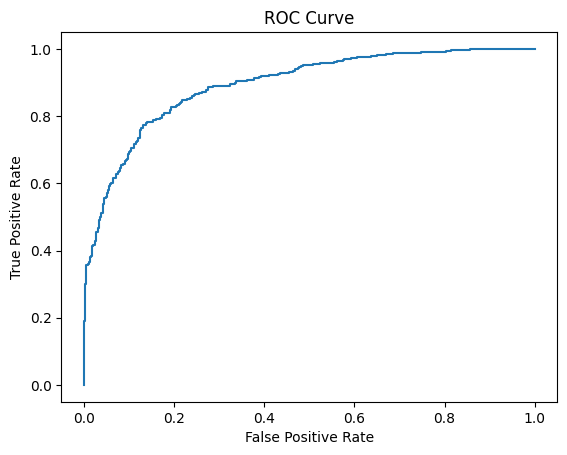

In [13]:
# @title Plot ROC.
roc_value_path = EA.plot_roc(pred_csv_path)

Add the new lables to the catalog using the provided diagnosis tage for this execution.  Also upload any additional assets that were produced by this execution..

In [14]:
# @title Save Diagnosis
import re
pred_df = pd.read_csv(pred_csv_path)
pred_df['Image'] = pred_df['Filename'].apply(lambda x: re.search(r'Cropped_(.*?)\.', x).group(1))
# The input dataframe need two columns: Image (containing image rid) and Prediction (containing 0/1)
EA.insert_new_diagnosis(pred_df,
                        configuration_records.vocabs['Diagnosis_Tag'][0].rid,
                        configuration_records.execution_rid)


In [17]:
# @title Save Execution Assets (model) and Metadata
uploaded_assets = EA.execution_upload(configuration_records.execution_rid, True)


2024-06-26 07:57:31,782 - INFO - Initializing uploader: GenericUploader v1.7.1 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2024-06-26 07:57:31,783 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-06-26 07:57:31,783 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2024-06-26 07:57:31,818 - INFO - Checking for updated configuration...
2024-06-26 07:57:31,942 - INFO - Updated configuration found.
2024-06-26 07:57:31,943 - INFO - Scanning files in directory [/data/sreenidhi/EyeAI_working/Execution_Assets/Model_Prediction]...
2024-06-26 07:57:31,947 - INFO - Including file: [/data/sreenidhi/EyeAI_working/Execution_Assets/Model_Prediction/predictions_results.csv].
2024-06-26 07:57:31,948 - INFO - Processing: [/data/sreenidhi/EyeAI_working/Execution_Assets/Model